# Image features exercise

*Complete and hand in the completed notebook (including the output) with your assignment submission. You will be submitting the homework as a zip file including all the parts on the Blackboard.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise, we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
## Default modules
from __future__ import print_function
import random
import numpy as np
import matplotlib.pyplot as plt
import pixiedust
## Custom modules
from ie590.data_utils import load_CIFAR10

## Ipython setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Pixiedust database opened successfully


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from ie590.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ie590/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from ie590.features import *

num_color_bins = 10 # Number of bins in the color histogram
## By default, we are using HOG, LBP and Color histogram features. Try other combinations.
feature_fns = [hog_feature, lbp_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from ie590.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
#                          START OF YOUR CODE                                  #
################################################################################
#pass ## Write your code here
for i in learning_rates:
    for j in regularization_strengths:
        svm_tune = LinearSVM()
        loss_hist_tune = svm_tune.train(X_train_feats, y_train, learning_rate=i, reg=j, num_iters=1500, verbose=False)
        # predict
        y_train_pred_tune = svm_tune.predict(X_train_feats)
        y_val_pred_tune = svm_tune.predict(X_val_feats)
        # accuracy
        acc_train_tune = np.mean(y_train == y_train_pred_tune)
        acc_val_tune = np.mean(y_val == y_val_pred_tune)
        # yay!
        results[i,j] = (acc_train_tune, acc_val_tune)
        if best_val < acc_val_tune:
            best_svm = svm_tune
            best_val = acc_val_tune
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.087898 val accuracy: 0.078000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.088653 val accuracy: 0.076000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.412265 val accuracy: 0.425000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.108163 val accuracy: 0.096000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413102 val accuracy: 0.421000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.417776 val accuracy: 0.425000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.416000 val accuracy: 0.428000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.398020 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.305347 val accuracy: 0.320000
best validation accuracy achieved during cross-validation: 0.428000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.434


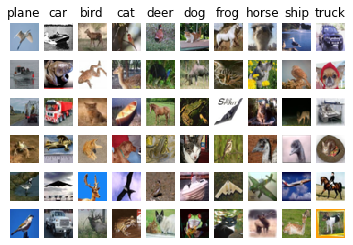

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 6
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 181)
(49000, 180)


In [8]:
from ie590.classifiers.neural_net_relu import TwoLayerNet
from itertools import product as iterprod

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
#pass # Write your code here
best_acc = -1

# Hyperparameters
learning_rate = [5e-1, 1e-1,5e-2, 1e-2]
reg = [5e-3, 1e-3, 5e-4, 1e-4, 5e-4, 1e-5]
# combinations of hyperparameters
hyperCombs = list(iterprod(learning_rate, reg))
totalCombs = len(hyperCombs)
val_acc = np.zeros(totalCombs)
n = 0

# sweeping through all combinations
for hC in hyperCombs:
    # train
    net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1000, batch_size=200,
        learning_rate=hC[0], learning_rate_decay=0.95,
        reg=hC[1], verbose=False)
    # accuracy
    val_acc = (net.predict(X_val_feats) == y_val).mean()

    # yay!
    if val_acc > best_acc:
        best_net = net
        best_acc = val_acc
    # print    
    n += 1
    print ('[%02d/%d] learning_rate:%8.1E  reg:%8.1E ---> %f' % (n,totalCombs,hC[0],hC[1],val_acc))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[01/24] learning_rate: 5.0E-01  reg: 5.0E-03 ---> 0.536000
[02/24] learning_rate: 5.0E-01  reg: 1.0E-03 ---> 0.588000
[03/24] learning_rate: 5.0E-01  reg: 5.0E-04 ---> 0.583000
[04/24] learning_rate: 5.0E-01  reg: 1.0E-04 ---> 0.593000
[05/24] learning_rate: 5.0E-01  reg: 5.0E-04 ---> 0.599000
[06/24] learning_rate: 5.0E-01  reg: 1.0E-05 ---> 0.570000
[07/24] learning_rate: 1.0E-01  reg: 5.0E-03 ---> 0.621000
[08/24] learning_rate: 1.0E-01  reg: 1.0E-03 ---> 0.619000
[09/24] learning_rate: 1.0E-01  reg: 5.0E-04 ---> 0.611000
[10/24] learning_rate: 1.0E-01  reg: 1.0E-04 ---> 0.619000
[11/24] learning_rate: 1.0E-01  reg: 5.0E-04 ---> 0.613000
[12/24] learning_rate: 1.0E-01  reg: 1.0E-05 ---> 0.606000
[13/24] learning_rate: 5.0E-02  reg: 5.0E-03 ---> 0.619000
[14/24] learning_rate: 5.0E-02  reg: 1.0E-03 ---> 0.618000
[15/24] learning_rate: 5.0E-02  reg: 5.0E-04 ---> 0.622000
[16/24] learning_rate: 5.0E-02  reg: 1.0E-04 ---> 0.618000
[17/24] learning_rate: 5.0E-02  reg: 5.0E-04 ---> 0.6140

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.605
